In [1]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import kWaveGrid
from models.pact import SOS2Wavefront
from utils.dataio import *
from utils.reconstruction import get_coordinates
from utils.simulations import get_water_sos
from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/numerical/'

### Load Images

In [2]:
v_das = 1510

In [3]:
IP_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
IP_das = load_mat(os.path.join(RESULTS_DIR, 'DAS', 'v_das={:.1f}m·s⁻¹'.format(v_das), 'IP_rec.mat'))
IP_dual_das = load_mat(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'IP_rec.mat'))
IP_deconv = load_mat(os.path.join(RESULTS_DIR, 'Deconv', '32delays', 'IP_rec.mat'))
IP_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'IP_rec.mat'))
IP_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'IP_rec.mat'))

SOS_gt = load_mat(os.path.join(DATA_DIR, 'SOS_easy.mat'))
SOS_uniform = load_mat(os.path.join(DATA_DIR, 'SOS_uniform.mat'))
SOS_dual = load_mat(os.path.join(DATA_DIR, 'SOS_SB.mat'))
SOS_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'SOS_rec.mat'))
SOS_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'SOS_rec.mat'))

t_das = load_log(os.path.join(RESULTS_DIR, 'DAS', 'v_das={:.1f}m·s⁻¹'.format(v_das), 'log.json'))['time']
t_dual_das = load_log(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'log.json'))['time']
t_deconv = load_log(os.path.join(RESULTS_DIR, 'Deconv', '32delays', 'log.json'))['time']
t_apact = load_log(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'log.json'))['time']
t_nf_apact = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'log.json'))['time']

In [4]:
[IP_gt, IP_das, IP_dual_das, IP_deconv, IP_apact, IP_nf_apact] = \
    [standardize(img) for img in [IP_gt, IP_das, IP_dual_das, IP_deconv, IP_apact, IP_nf_apact]]
data_range_img = 13 #  IP_das.max() - IP_das.min()
data_range_SOS = SOS_gt.max() - SOS_gt.min()

In [5]:
# IP_gt.max(), IP_gt.min(), IP_das.max(), IP_das.min(), IP_dual_das.max(), IP_dual_das.min(), IP_apact.max(), IP_apact.min(), IP_nf_apact.max(), IP_nf_apact.min()

### Calculate Wavefronts

In [6]:
config = load_config(os.path.join('../', 'config.yaml'))
bps, tps = config['basic_params'], config['numerical']
R_ring = bps['R_ring'] # Radius to ring [m].
R_body = tps['R_body'] # Radius to center [m].
l_patch = bps['l_patch'] # Patch size [m].
kgrid = kWaveGrid([tps['Nx'], tps['Ny']], [bps['dx'], bps['dy']])
v0 = get_water_sos(tps['T'])

In [7]:
sos2wf = SOS2Wavefront(R_body, v0, kgrid.x_vec, kgrid.y_vec, n_thetas=360)
sos2wf.cuda()
sos2wf.eval()

SOS2Wavefront()

Pick a patch.

In [8]:
i, j = 18, 15
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, l_patch)
x, y = (j-12)*l_patch / 4, (12-i)*l_patch / 4
k2D, theta2D = get_fourier_coord(N=80, l=l_patch, device='cpu')
print(r*1e3, phi)

5.366563145999496 2.677945044588987


Calculate ground truth and NF-APACT wavefronts.

In [9]:
thetas, wf_gt = sos2wf(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_gt).cuda())
wf_gt = wf_gt.detach().cpu().numpy()
thetas, wf_dual = sos2wf(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_dual).cuda())
wf_dual = wf_dual.detach().cpu().numpy()
thetas, wf_nf_apact = sos2wf(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_nf_apact).cuda())
wf_nf_apact = wf_nf_apact.detach().cpu().numpy()
thetas = thetas.detach().cpu().numpy()
wf_das = np.ones_like(wf_gt) * R_ring * (1-v0/v_das)

Calculate APACT wavefront.

In [10]:
wf_params = torch.load(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'wf_params.pth')).detach().cpu().numpy()
dc ,x2, y2 = wf_params[i*25+j]
wf_apact = dc + x2*np.cos(2*thetas) + y2*np.sin(2*thetas)

### Create Figure

/home/tianao/anaconda3/envs/pact/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


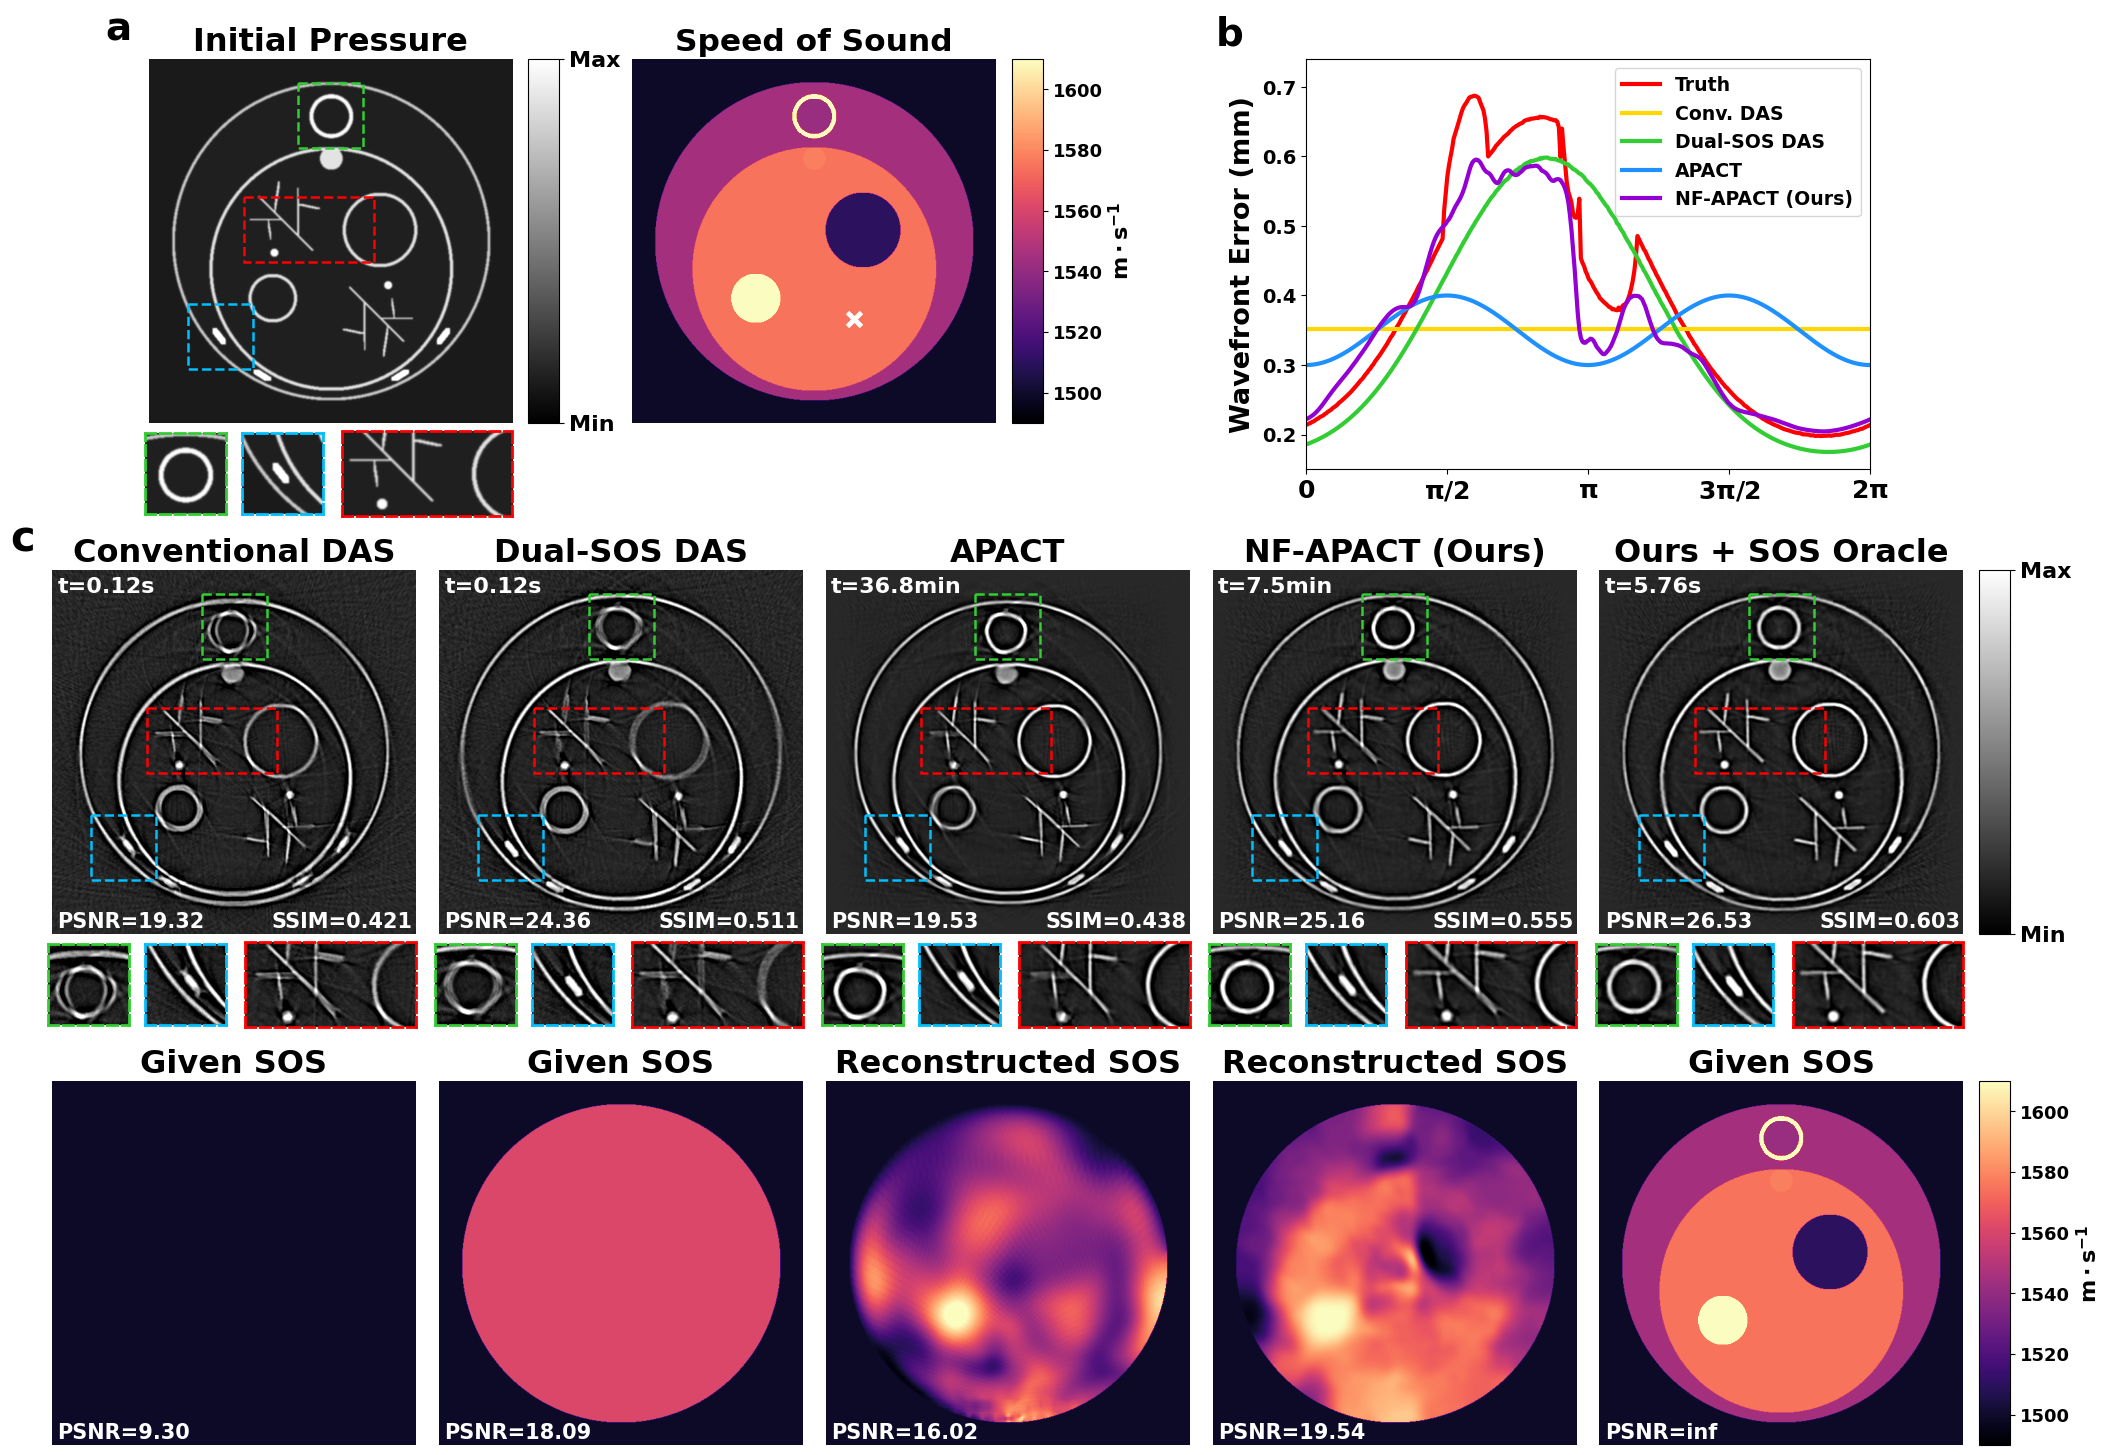

In [11]:
patches = [(36, 230, 100, 100, 'limegreen'), (377, 60, 100, 100, 'deepskyblue'), (212, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(26, 18))
gs = GridSpec(30, 21)
norm = Normalize(vmax=5, vmin=-1)
norm_SOS = Normalize(vmax=1610, vmin=1490)

# Panel a: Numerical phantom.
ax = plt.subplot(gs[0:8,1:5])
plt.title('a', loc='left', x=-0.12, y=1.03, fontsize=28, fontweight='semibold', color='black')
plt.title('Initial Pressure', fontsize=23, fontweight='semibold')
plt.axis('off')
plt.imshow(IP_gt, cmap='gray', norm=norm)
cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.set_ticks([5, -1])
cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[8:10,k+1:k+2+(k==2)])
        plt.imshow(IP_gt[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

ax = plt.subplot(gs[0:8,6:10])
plt.axis('off')
plt.title('Speed of Sound', fontsize=22.5, fontweight='semibold')
plt.imshow(SOS_gt, cmap='magma', norm=norm_SOS)
plt.plot(idy, idx, marker='x', mew=3.5, color='white', markersize=10)
cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_SOS)
cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
cb.set_label('$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold')

# Panel b: comaping Wavefronts.
plt.subplot(gs[0:9,13:19])
plt.plot(thetas, wf_gt*1e3, label='Truth', color='red', linewidth=3.)
plt.plot(thetas, wf_das*1e3, label='Conv. DAS', color='gold', linewidth=3.)
plt.plot(thetas, wf_dual*1e3, label='Dual-SOS DAS', color='limegreen', linewidth=3.)
plt.plot(thetas, wf_apact*1e3, label='APACT', color='dodgerblue', linewidth=3.)
plt.plot(thetas, wf_nf_apact*1e3, label='NF-APACT (Ours)', color='darkviolet', linewidth=3.)
plt.legend(prop=dict(weight='bold', size=13.6))
plt.xlim([0, 2*np.pi])
plt.ylim([0.15, 0.74])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
           ['$\mathbf{0}$', '$\mathbf{\pi/2}$', '$\mathbf{\pi}$', '$\mathbf{3\pi/2}$', '$\mathbf{2\pi}$'], fontsize=18)
plt.yticks(fontsize=14, fontweight='bold')
plt.ylabel('Wavefront Error (mm)', fontsize=19.5, fontweight='bold')
plt.text(s='b', x=-1, y=0.76, fontsize=28, fontweight='semibold', color='black')

# Panel c: Reconstruction results.
for idx, (img, method, time, SOS, SOS_title) in enumerate(zip([IP_das, IP_dual_das,  IP_apact, IP_nf_apact, IP_deconv],
                                                              ['Conventional DAS', 'Dual-SOS DAS', 'APACT', 'NF-APACT (Ours)', 'Ours + SOS Oracle'],
                                                              ['t={:.2f}s'.format(t_das), 't={:.2f}s'.format(t_dual_das), 't={:.1f}min'.format(t_apact/60), 't={:.1f}min'.format(t_nf_apact/60), 't={:.2f}s'.format(t_deconv)],
                                                              [SOS_uniform, SOS_dual, SOS_apact, SOS_nf_apact, SOS_gt],
                                                              ['Given SOS', 'Given SOS', 'Reconstructed SOS', 'Reconstructed SOS', 'Given SOS'])):
    ax = plt.subplot(gs[11:19,idx*4:(idx+1)*4])
    plt.title(method, fontsize=23, fontweight='semibold')
    plt.axis('off')
    plt.imshow(img, cmap='gray', norm=norm)
    plt.text(s=time, x=8, y=34, fontweight='semibold', fontsize=16, color='white')
    plt.text(s='PSNR={:.2f}'.format(psnr(IP_gt, img, data_range=data_range_img)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(IP_gt, img, data_range=data_range_img)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if idx == 0:
        plt.text(s='c', x=-65, y=-30, fontsize=30, fontweight='semibold', color='black')
    elif idx == 4:
        cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
    
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[19:21,idx*4+k:idx*4+k+1+(k==2)])
        plt.imshow(img[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

    ax = plt.subplot(gs[22:30,idx*4:(idx+1)*4])
    plt.axis('off')
    plt.title(SOS_title, fontsize=23, fontweight='semibold')
    plt.imshow(SOS, cmap='magma', norm=norm_SOS)
    if idx >= 0:
        plt.text(s='PSNR={:.2f}'.format(psnr(SOS, SOS_gt, data_range=data_range_SOS)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    if idx == 4:
        cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        cb.set_label('$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold')
    
plt.savefig('figure_simulation.png', bbox_inches='tight', dpi=256)